We have mounted Google Drive within the Colab environment. The dataset, organized into two specific folders:

signature_images: Contains all the signature images in .jpg format.

signature_annotations: Holds the corresponding YOLO-format .txt annotation files.

In [5]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)


Mounted at /content/drive


---

### Testing the Models: YOLOv5 and Detectron2

For testing, I used both **YOLOv5** and **Detectron2** models to detect signatures. YOLOv5 was chosen because it requires less computational power and is well-suited for lightweight tasks. Detectron2, on the other hand, is more robust and versatile, making it great for more detailed predictions.

Both models were tested on the same set of images to compare their performance. While YOLOv5 provided quick predictions, Detectron2 offered a different perspective with its custom configurations. Using these two models allowed for a thorough evaluation of signature detection capabilities.

---

In [2]:
# Clone YOLOv5 repository
!git clone https://github.com/ultralytics/yolov5
%cd yolov5

# Install dependencies
!pip install -r requirements.txt
!pip install albumentations


Cloning into 'yolov5'...
remote: Enumerating objects: 17080, done.
remote: Counting objects: 100% (30/30), done.
remote: Compressing objects: 100% (25/25), done.
remote: Total 17080 (delta 20), reused 5 (delta 5), pack-reused 17050 (from 4)
Receiving objects: 100% (17080/17080), 15.70 MiB | 15.55 MiB/s, done.
Resolving deltas: 100% (11721/11721), done.
/content/yolov5
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 904.3/904.3 kB 27.9 MB/s eta 0:00:00


In [3]:
import torch

print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
print(f"GPU: {torch.cuda.get_device_name(0) if torch.cuda.is_available() else 'CPU'}")


PyTorch version: 2.5.1+cu121
CUDA available: True
GPU: Tesla T4


---

### Data Augmentation and Verification

In this code block, the dataset preparation process involves splitting, augmenting, and verifying the training dataset to enhance model performance and robustness.

#### **Dataset Splitting**
The original dataset is stored in the Google Drive folders `signature_images` (for images) and `signature_annotations` (for bounding box annotations in YOLO format). The dataset is divided into **training** (80%) and **validation** (20%) sets. Separate directories are created to store the training and validation images and their respective annotations.

#### **Augmentation Pipeline**
To improve model generalization, an augmentation pipeline is defined using the `albumentations` library. Augmentation techniques include:
- **Horizontal and Vertical Flipping**: Randomly flips images for variability.
- **Rotation**: Rotates images within a range of 45°.
- **Brightness and Contrast Adjustment**: Adds brightness/contrast variations.
- **Gaussian Blur**: Smooths images.
- **Hue, Saturation, and Value Adjustment**: Randomly changes color properties.
- **Shift, Scale, and Rotate**: Applies affine transformations.
- **Bounding Box Safety Crop**: Ensures bounding boxes remain valid after cropping.

Bounding boxes are adjusted to remain within the valid range `[0, 1]`.

#### **Data Augmentation**
Each training image is augmented multiple times (5 in this case) to artificially expand the dataset:
1. Images and annotations are read from the respective folders.
2. The augmentation pipeline is applied to each image and its associated bounding boxes.
3. Augmented images are saved in the `train_augmented` folder, and corresponding YOLO-format annotations are stored in `labels/train_augmented`.

Any errors encountered during augmentation, such as invalid bounding box formats or missing annotations, are logged for debugging.

#### **Verification**
To ensure the consistency of augmented data, a verification process checks that every augmented image has a corresponding annotation file. If mismatches are detected, they are reported.

In [7]:
import albumentations as A
import cv2
import os
import shutil
from sklearn.model_selection import train_test_split


drive_base = '/content/drive/MyDrive/'
image_folder = os.path.join(drive_base, 'signature_images')  # Folder containing original images
annotation_folder = os.path.join(drive_base, 'signature_annotations')  # Folder containing .txt annotations

# Dataset paths
dataset_dir = '/content/dataset'
train_images_dir = os.path.join(dataset_dir, 'images', 'train')
val_images_dir = os.path.join(dataset_dir, 'images', 'val')
train_labels_dir = os.path.join(dataset_dir, 'labels', 'train')
val_labels_dir = os.path.join(dataset_dir, 'labels', 'val')

# Augmented data paths
augmented_images_dir = os.path.join(dataset_dir, 'images', 'train_augmented')
augmented_labels_dir = os.path.join(dataset_dir, 'labels', 'train_augmented')

# Create directories
os.makedirs(train_images_dir, exist_ok=True)
os.makedirs(val_images_dir, exist_ok=True)
os.makedirs(train_labels_dir, exist_ok=True)
os.makedirs(val_labels_dir, exist_ok=True)
os.makedirs(augmented_images_dir, exist_ok=True)
os.makedirs(augmented_labels_dir, exist_ok=True)

# Splitting
images = sorted([f for f in os.listdir(image_folder) if f.endswith('.jpg')])
train_images, val_images = train_test_split(images, test_size=0.2, random_state=42)

def copy_files(image_list, src_img, src_lbl, dest_img, dest_lbl):
    for img in image_list:
        shutil.copy(os.path.join(src_img, img), dest_img)
        lbl = img.replace('.jpg', '.txt')
        shutil.copy(os.path.join(src_lbl, lbl), dest_lbl)

# Copy files to train/val folders
copy_files(train_images, image_folder, annotation_folder, train_images_dir, train_labels_dir)
copy_files(val_images, image_folder, annotation_folder, val_images_dir, val_labels_dir)

# Define augmentation pipeline
augmentation_pipeline = A.Compose(
    [
        A.HorizontalFlip(p=0.5),
        A.VerticalFlip(p=0.5),
        A.Rotate(limit=45, p=0.7),
        A.RandomBrightnessContrast(p=0.5),
        A.GaussianBlur(blur_limit=3, p=0.3),
        A.HueSaturationValue(p=0.3),
        A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.1, rotate_limit=15, p=0.5),
        A.RandomSizedBBoxSafeCrop(height=640, width=640, p=0.5),
    ],
    bbox_params=A.BboxParams(
        format='yolo',            # YOLO format bounding boxes
        label_fields=['class_labels'],  # Associate bounding boxes with class labels
        min_visibility=0.3        # Minimum visibility for bounding boxes
    ),
)

# Augment images and annotations
def augment_images():
    num_augments = 5  # Number of augmentations per image
    for img_file in os.listdir(train_images_dir):
        if img_file.endswith('.jpg'):
            img_path = os.path.join(train_images_dir, img_file)
            label_path = os.path.join(train_labels_dir, img_file.replace('.jpg', '.txt'))

            # Read image
            image = cv2.imread(img_path)
            if image is None:
                print(f"Failed to read image: {img_path}")
                continue
            img_height, img_width = image.shape[:2]

            # Read label
            if not os.path.exists(label_path):
                print(f"Annotation file missing for image: {img_file}")
                continue
            with open(label_path, 'r') as f:
                lines = f.readlines()

            bboxes = []
            class_ids = []
            for line in lines:
                parts = line.strip().split()
                if len(parts) != 5:
                    print(f"Invalid annotation format in {label_path}: {line}")
                    continue
                class_id = int(parts[0])
                bbox = list(map(float, parts[1:]))
                bboxes.append(bbox)
                class_ids.append(class_id)

            # Apply multiple augmentations
            for i in range(num_augments):
                try:
                    augmented = augmentation_pipeline(image=image, bboxes=bboxes, class_labels=class_ids)
                    aug_image = augmented['image']
                    aug_bboxes = augmented['bboxes']
                    aug_class_ids = augmented['class_labels']

                    if len(aug_bboxes) == 0:
                        print(f"No bounding boxes after augmentation for {img_file}_aug_{i}.jpg")
                        continue

                    # Save augmented image
                    aug_img_filename = img_file.replace('.jpg', f'_aug_{i}.jpg')
                    aug_img_path = os.path.join(augmented_images_dir, aug_img_filename)
                    cv2.imwrite(aug_img_path, aug_image)

                    # Save augmented labels
                    aug_lbl_filename = aug_img_filename.replace('.jpg', '.txt')
                    aug_lbl_path = os.path.join(augmented_labels_dir, aug_lbl_filename)
                    with open(aug_lbl_path, 'w') as f:
                        for bbox, cls_id in zip(aug_bboxes, aug_class_ids):
                            bbox = [max(min(coord, 1), 0) for coord in bbox]
                            bbox_str = ' '.join([f"{coord:.6f}" for coord in bbox])
                            f.write(f"{cls_id} {bbox_str}\n")
                except Exception as e:
                    print(f"Augmentation failed for {img_file} on iteration {i}: {e}")


augment_images()

# Verify augmented data
def verify_augmented_data():
    augmented_images = [f for f in os.listdir(augmented_images_dir) if f.endswith('.jpg')]
    augmented_labels = [f for f in os.listdir(augmented_labels_dir) if f.endswith('.txt')]

    missing_labels = [img.replace('.jpg', '.txt') for img in augmented_images if img.replace('.jpg', '.txt') not in augmented_labels]

    if not missing_labels:
        print("All augmented images have corresponding labels.")
    else:
        print(f"Missing labels for {len(missing_labels)} augmented images:")
        for lbl in missing_labels:
            print(lbl)


verify_augmented_data()


/usr/local/lib/python3.10/dist-packages/pydantic/main.py:214: UserWarning: blur_limit and sigma_limit minimum value can not be both equal to 0. blur_limit minimum value changed to 3.
  validated_self = self.__pydantic_validator__.validate_python(data, self_instance=self)


All augmented images have corresponding labels.


---

### Preparing the Final Dataset for Training

After augmenting the images and ensuring all augmented images have corresponding annotations, the next step involves **merging the augmented dataset** with the original training dataset. This final, enriched dataset combines the original images and annotations with the augmented ones, increasing the dataset's diversity and robustness.

The **final dataset** will then be used for training both models, YOLOv5 and Detectron2

---

In [8]:
import shutil

# Merge augmented training images and labels into the main training directories
for img_file in os.listdir(augmented_images_dir):
    if img_file.endswith('.jpg'):
        shutil.copy(os.path.join(augmented_images_dir, img_file), train_images_dir)
        shutil.copy(os.path.join(augmented_labels_dir, img_file.replace('.jpg', '.txt')), train_labels_dir)

print("Augmented data merged into the training set.")


Augmented data merged into the training set.


--2024-12-29 17:35:15--  https://ultralytics.com/images/zidane.jpg
Resolving ultralytics.com (ultralytics.com)... 99.83.190.102, 75.2.70.75
Connecting to ultralytics.com (ultralytics.com)|99.83.190.102|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://www.ultralytics.com/images/zidane.jpg [following]
--2024-12-29 17:35:15--  https://www.ultralytics.com/images/zidane.jpg
Resolving www.ultralytics.com (www.ultralytics.com)... 172.64.147.154, 104.18.40.102, 2606:4700:4400::ac40:939a, ...
Connecting to www.ultralytics.com (www.ultralytics.com)|172.64.147.154|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://github.com/ultralytics/assets/releases/download/v0.0.0/zidane.jpg [following]
--2024-12-29 17:35:15--  https://github.com/ultralytics/assets/releases/download/v0.0.0/zidane.jpg
Resolving github.com (github.com)... 140.82.114.3
Connecting to github.com (github.com)|140.82.114.3|:443... conne

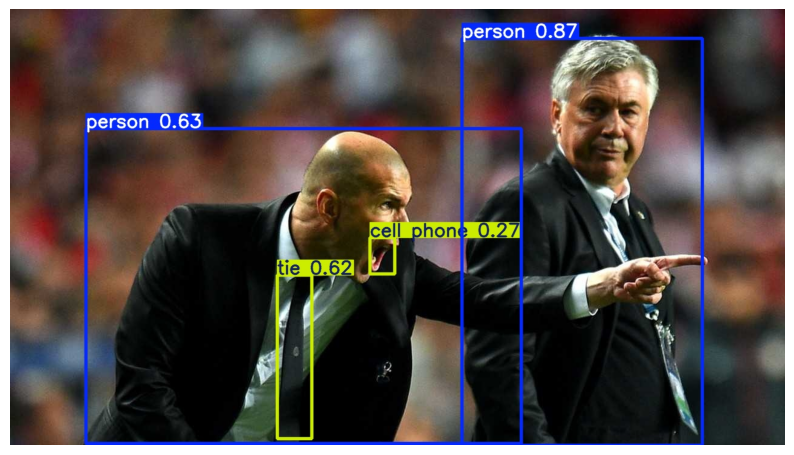

In [9]:
# Download a sample image for verification
!wget https://ultralytics.com/images/zidane.jpg -O sample.jpg

# Run inference using pre-trained YOLOv5s model
!python detect.py --weights yolov5s.pt --img 640 --conf 0.25 --source sample.jpg --save-txt --save-conf

# Display the detected image
from PIL import Image
import matplotlib.pyplot as plt

result_image = Image.open('runs/detect/exp/sample.jpg')
plt.figure(figsize=(10,10))
plt.imshow(result_image)
plt.axis('off')
plt.show()


---

### Verifying Pre-trained YOLOv5s Model with a Sample Image

To ensure the YOLOv5s model is functioning correctly, a **sample image (`zidane.jpg`)** was downloaded and used for inference. This image contains multiple objects, and the YOLOv5s model was tasked with detecting and labeling these objects. Below are the key steps and results:

1. **Download Sample Image**:
   - The Zidane image was downloaded from the Ultralytics GitHub repository and saved locally as `sample.jpg`.

2. **Run YOLOv5 Inference**:
   - A pre-trained YOLOv5s model was used to detect objects in the sample image.
   - The model was executed with the following configurations:
     - Image size: `640x640`
     - Confidence threshold: `0.25`
     - Non-Max Suppression (NMS) threshold: `0.45`
   - Results, including bounding boxes, labels, and confidence scores, were saved in the output directory (`runs/detect/exp`).

Now, I will create custom yaml for Yolo model.

In [18]:
import yaml

data_config = {
    'train': '/content/dataset/images/train',
    'val': '/content/dataset/images/val',
    'test': '/content/test/train/images',
    'nc': 1,
    'names': ['signature']
}
data_yaml_path = '/content/yolov5/custom_data.yaml'
with open(data_yaml_path, 'w') as f:
    yaml.dump(data_config, f)

print(f"custom_data.yaml created at {data_yaml_path}")


custom_data.yaml created at /content/yolov5/custom_data.yaml


In [19]:
# I need to verify it too because it caused error previously due to some path issues
with open(data_yaml_path, 'r') as f:
    data_content = f.read()

print("Contents of custom_data.yaml:")
print(data_content)


Contents of custom_data.yaml:
names:
- signature
nc: 1
test: /content/test/train/images
train: /content/dataset/images/train
val: /content/dataset/images/val



During the annotation phase, LabelImg was used to generate bounding box annotations for the dataset. However, instead of assigning the class ID 0 for the "signature" class, the tool incorrectly assigned the class ID 15 to every bounding box. This inconsistency arose due to a misconfiguration in LabelImg, where class indexing started at an incorrect value.

To correct this, a script was developed to traverse through all label files in both training and validation datasets. The script updates the class ID in every annotation line to 0, ensuring consistency for YOLOv5's single-class object detection model.

In [13]:
import os

train_labels_dir = '/content/dataset/labels/train'
val_labels_dir = '/content/dataset/labels/val'

# Function to fix label files
def fix_labels(label_dir):
    for label_file in os.listdir(label_dir):
        if label_file.endswith('.txt'):
            label_path = os.path.join(label_dir, label_file)
            with open(label_path, 'r') as f:
                lines = f.readlines()

            # Fix class IDs
            fixed_lines = []
            for line in lines:
                parts = line.strip().split()
                if len(parts) > 0:
                    parts[0] = '0'  # Replace class ID with 0
                    fixed_lines.append(' '.join(parts))

            # Write fixed labels back to file
            with open(label_path, 'w') as f:
                f.writelines('\n'.join(fixed_lines) + '\n')

# Fix labels in both train and validation directories
fix_labels(train_labels_dir)
fix_labels(val_labels_dir)

print("Labels fixed. All class IDs are set to 0.")


Labels fixed. All class IDs are set to 0.


Our main issue stemmed from having only 25 annotated images in the dataset. This caused several challenges:

Limited Training Data: The small dataset size made it difficult to train models effectively, as deep learning models typically require large datasets to generalize well.

Overfitting Risk: With so few images, the models were prone to overfitting, learning to perform well only on the training set but struggling with unseen data.

Class Imbalance in Labels: Initial labeling using LabelImg resulted in incorrect class IDs due to limited samples, which had to be manually corrected.

Augmentation Dependency: To address the dataset's size limitations, we heavily relied on augmentations to artificially expand the data. This increased the preprocessing workload.

---

### Preparing for Model Training

After completing the necessary preprocessing and corrections, the dataset is now ready for training. The key steps undertaken are summarized below:

- Mounted the dataset from Google Drive and organized it into training and validation splits.
- Annotated the images using **LabelImg**, then fixed label inconsistencies caused by incorrect class IDs.
- Augmented the dataset using **Albumentations** to increase data diversity and improve model generalization.
- Verified the consistency of augmented data by ensuring every augmented image had a corresponding label file.
- Created a **custom YAML configuration** for YOLOv5, specifying the training, validation, and test datasets along with class details.
- Resolved all issues related to class IDs in the label files by ensuring the correct class ID (`0`) was assigned to all annotations.

With these steps complete, the dataset is prepped and ready for training both the **YOLOv5** and **Detectron2** models.

---

In [14]:
%cd yolov5


dataset_yaml_path = '/content/yolov5/custom_data.yaml'

# Train the YOLOv5x model
!python train.py \
--img 640 \
--batch 16 \
--epochs 150 \
--data {dataset_yaml_path} \
--weights yolov5x.pt \
--cache

[Errno 2] No such file or directory: 'yolov5'
/content/yolov5
wandb: WARNING ⚠️ wandb is deprecated and will be removed in a future release. See supported integrations at https://github.com/ultralytics/yolov5#integrations.
2024-12-29 17:37:57.553859: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-12-29 17:37:57.573394: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-12-29 17:37:57.580474: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: (1) Create a W&B account

**Training YOLOv5x Model**

The YOLOv5x model was trained on the prepared dataset with the following key parameters:

- **Image size:** 640x640
- **Batch size:** 16
- **Epochs:** 150
- **Pre-trained weights:** `yolov5x.pt` (transfer learning)

### Key Results:

1. **Model Summary:**
   - **Layers:** 322
   - **Parameters:** 86,173,414
   - **GFLOPs:** 203.8

2. **Validation Metrics:**
   - **Precision (P):** 0.99
   - **Recall (R):** 1.0
   - **mAP@0.5:** 0.995
   - **mAP@0.5:0.95:** 0.754

3. **Best Weights:**
   - Saved to `runs/train/exp/weights/best.pt`.

### Observations:

- **High Precision and Recall:** Indicates the model effectively detects the "signature" class with minimal false positives and negatives.
- **Transfer Learning Effectiveness:** Using pre-trained weights helped achieve high performance despite a small dataset.

The results demonstrate that YOLOv5x is well-suited for this task, even with limited data, due to its capability to generalize effectively.

In [15]:
!find /content/yolov5 -name "best.pt"

/content/yolov5/runs/train/exp/weights/best.pt


Now, we will use Detectron2 to see how it performs


In [22]:
!pip install 'git+https://github.com/facebookresearch/detectron2.git'


  Cloning https://github.com/facebookresearch/detectron2.git to /tmp/pip-req-build-xp2pddvi
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/detectron2.git /tmp/pip-req-build-xp2pddvi
  Resolved https://github.com/facebookresearch/detectron2.git to commit b1c43ffbc995426a9a6b5c667730091a384e0fa4
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.2/50.2 kB 3.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.2/79.2 kB 5.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.0/117.0 kB 11.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.5/154.5 kB 16.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.5/79.5 kB 8.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 54.6 MB/s eta 0:00:00
  Created wheel for detectron2: filename=detectron2-0.6-cp3

In [35]:
import detectron2
print("Detectron2 is installed successfully.")


Detectron2 is installed successfully.


**Annotation Conversion for Detectron2**  

This was my first time using Detectron2, which required annotations in the COCO format instead of YOLO format. To accommodate this, we had to:  

1. **Convert YOLO Annotations to COCO Format:**  
   - YOLO annotations use normalized bounding box coordinates, while COCO requires absolute coordinates.  
   - Each YOLO annotation was parsed and transformed into the required COCO structure.  

2. **Handle Class Labels:**  
   - YOLO uses numerical class IDs, but COCO requires named categories.  
   - Ensured all instances were labeled as "signature" for this task.  

3. **Dataset Structure:**  
   - Organized the dataset into COCO-compatible folders with separate paths for images and annotations.  



In [29]:
import os
import json
import cv2

def yolo_to_coco(image_dir, label_dir, output_json, class_names):
    coco_dict = {
        "images": [],
        "annotations": [],
        "categories": [{"id": i, "name": name} for i, name in enumerate(class_names)],
    }
    annotation_id = 1

    for image_id, image_file in enumerate(sorted(os.listdir(image_dir))):
        if not image_file.endswith(".jpg"):
            continue
        # Image details
        image_path = os.path.join(image_dir, image_file)
        height, width = cv2.imread(image_path).shape[:2]
        coco_dict["images"].append({
            "id": image_id,
            "file_name": image_file,
            "height": height,
            "width": width,
        })


        label_file = os.path.join(label_dir, image_file.replace(".jpg", ".txt"))
        if os.path.exists(label_file):
            with open(label_file, "r") as f:
                lines = f.readlines()
                for line in lines:
                    class_id, x_center, y_center, bbox_width, bbox_height = map(float, line.strip().split())
                    bbox = [
                        (x_center - bbox_width / 2) * width,  # x_min
                        (y_center - bbox_height / 2) * height, # y_min
                        bbox_width * width,  # bbox_width
                        bbox_height * height, # bbox_height
                    ]
                    coco_dict["annotations"].append({
                        "id": annotation_id,
                        "image_id": image_id,
                        "category_id": int(class_id),
                        "bbox": bbox,
                        "area": bbox[2] * bbox[3],
                        "iscrowd": 0,
                    })
                    annotation_id += 1

    with open(output_json, "w") as f:
        json.dump(coco_dict, f, indent=4)
    print(f"COCO annotations saved to {output_json}")


yolo_to_coco(
    image_dir="/content/dataset/images/train",
    label_dir="/content/dataset/labels/train",
    output_json="/content/train_coco.json",
    class_names=["signature"]
)


COCO annotations saved to /content/train_coco.json


In [30]:
import os
import json
import cv2

def yolo_to_coco(image_dir, label_dir, output_json, class_names):
    coco_dict = {
        "images": [],
        "annotations": [],
        "categories": [{"id": i, "name": name} for i, name in enumerate(class_names)],
    }
    annotation_id = 1

    for image_id, image_file in enumerate(sorted(os.listdir(image_dir))):
        if not image_file.endswith(".jpg"):
            continue
        # Image details
        image_path = os.path.join(image_dir, image_file)
        height, width = cv2.imread(image_path).shape[:2]
        coco_dict["images"].append({
            "id": image_id,
            "file_name": image_file,
            "height": height,
            "width": width,
        })

        # Read corresponding YOLO label
        label_file = os.path.join(label_dir, image_file.replace(".jpg", ".txt"))
        if os.path.exists(label_file):
            with open(label_file, "r") as f:
                lines = f.readlines()
                for line in lines:
                    class_id, x_center, y_center, bbox_width, bbox_height = map(float, line.strip().split())
                    bbox = [
                        (x_center - bbox_width / 2) * width,  # x_min
                        (y_center - bbox_height / 2) * height, # y_min
                        bbox_width * width,  # bbox_width
                        bbox_height * height, # bbox_height
                    ]
                    coco_dict["annotations"].append({
                        "id": annotation_id,
                        "image_id": image_id,
                        "category_id": int(class_id),
                        "bbox": bbox,
                        "area": bbox[2] * bbox[3],
                        "iscrowd": 0,
                    })
                    annotation_id += 1

    with open(output_json, "w") as f:
        json.dump(coco_dict, f, indent=4)
    print(f"COCO annotations saved to {output_json}")


yolo_to_coco(
    image_dir="/content/dataset/images/val",
    label_dir="/content/dataset/labels/val",
    output_json="/content/val_coco.json",
    class_names=["signature"]
)


COCO annotations saved to /content/val_coco.json


I had to this conversion for both Training set and Validation set as it was already split earlier

**Dataset Registration and Visualization**  

To train the Detectron2 model, the dataset was first registered in COCO format. Here’s what was done:  

1. **Registering the Dataset:**  
   - `register_coco_instances` was used to register both the training and validation datasets.  
   - Paths to the COCO JSON files (`train_coco.json` and `val_coco.json`) and corresponding image directories were specified.  

2. **Metadata and Dataset Access:**  
   - Metadata for the "signature_train" dataset was retrieved to understand class mappings and dataset properties.  
   - The dataset itself was accessed using `DatasetCatalog` for further validation.

3. **Dataset Visualization:**  
   - Random samples were selected from the dataset and visualized using Detectron2’s `Visualizer`.  
   - This helped confirm that annotations were correctly displayed on the images, ensuring the data was properly prepared for training.  

This step verified the integrity of the dataset and ensured readiness for training.

Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.



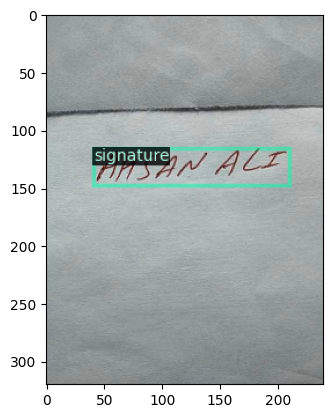

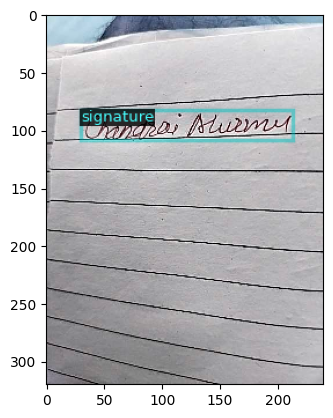

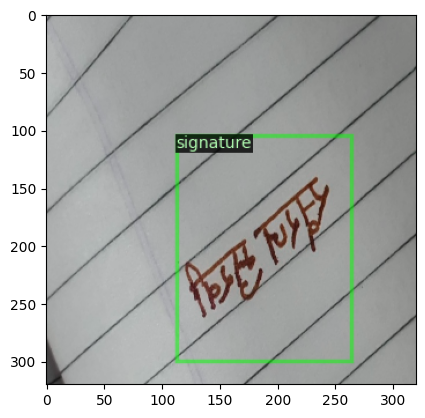

In [36]:
from detectron2.engine import DefaultTrainer
from detectron2.config import get_cfg
from detectron2.data import MetadataCatalog, DatasetCatalog
from detectron2.data.datasets import register_coco_instances

# Register COCO dataset
register_coco_instances("signature_train", {}, "/content/train_coco.json", "/content/dataset/images/train")
register_coco_instances("signature_val", {}, "/content/val_coco.json", "/content/dataset/images/val")

# Verify dataset
metadata = MetadataCatalog.get("signature_train")
dataset_dicts = DatasetCatalog.get("signature_train")

# Display a sample
import random
import cv2
from detectron2.utils.visualizer import Visualizer

for d in random.sample(dataset_dicts, 3):
    img = cv2.imread(d["file_name"])
    visualizer = Visualizer(img[:, :, ::-1], metadata=metadata, scale=0.5)
    vis = visualizer.draw_dataset_dict(d)
    plt.imshow(vis.get_image()[:, :, ::-1])
    plt.show()


We are Ready to go!!!

In [38]:
from detectron2.engine import DefaultTrainer
from detectron2.config import get_cfg
from detectron2.data import MetadataCatalog, DatasetCatalog
from detectron2.data.datasets import register_coco_instances
from detectron2.model_zoo import model_zoo # I got error here so had to Import model_zoo for accessing pre-defined configurations
from detectron2.config import get_cfg
from detectron2 import model_zoo
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml"))
cfg.DATASETS.TRAIN = ("signature_train",)
cfg.DATASETS.TEST = ("signature_val",)

cfg.DATALOADER.NUM_WORKERS = 2
cfg.MODEL.WEIGHTS = "detectron2://ImageNetPretrained/MSRA/R-50.pkl"  # Pre-trained weights
cfg.SOLVER.IMS_PER_BATCH = 2
cfg.SOLVER.BASE_LR = 0.00025
cfg.SOLVER.MAX_ITER = 15000  # Number of iterations
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 128
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 1

cfg.OUTPUT_DIR = "/content/detectron2_output"
os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)

trainer = DefaultTrainer(cfg)
trainer.resume_or_load(resume=False)
trainer.train()


[12/29 19:10:54 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

backbone.fpn_lateral2.{bias, weight}
backbone.fpn_lateral3.{bias, weight}
backbone.fpn_lateral4.{bias, weight}
backbone.fpn_lateral5.{bias, weight}
backbone.fpn_output2.{bias, weight}
backbone.fpn_output3.{bias, weight}
backbone.fpn_output4.{bias, weight}
backbone.fpn_output5.{bias, weight}
proposal_generator.rpn_head.anchor_deltas.{bias, weight}
proposal_generator.rpn_head.conv.{bias, weight}
proposal_generator.rpn_head.objectness_logits.{bias, weight}
roi_heads.box_head.fc1.{bias, weight}
roi_heads.box_head.fc2.{bias, weight}
roi_heads.box_predictor.bbox_pred.{bias, weight}
roi_heads.box_predictor.cls_score.{bias, weight}
  fc1000.{bias, weight}
  stem.conv1.bias


[12/29 19:10:55 d2.engine.train_loop]: Starting training from iteration 0
[12/29 19:11:01 d2.utils.events]:  eta: 1:19:39  iter: 19  total_loss: 1.218  loss_cls: 0.4536  loss_box_reg: 0.01761  loss_rpn_cls: 0.7098  loss_rpn_loc: 0.01083    time: 0.3290  last_time: 0.4041  data_time: 0.0170  last_data_time: 0.0051   lr: 4.9953e-06  max_mem: 2758M
[12/29 19:11:09 d2.utils.events]:  eta: 1:29:18  iter: 39  total_loss: 0.905  loss_cls: 0.1789  loss_box_reg: 0.00103  loss_rpn_cls: 0.7006  loss_rpn_loc: 0.009005    time: 0.3513  last_time: 0.3895  data_time: 0.0186  last_data_time: 0.0294   lr: 9.9902e-06  max_mem: 2758M
[12/29 19:11:16 d2.utils.events]:  eta: 1:29:52  iter: 59  total_loss: 0.7911  loss_cls: 0.0781  loss_box_reg: 0.0007927  loss_rpn_cls: 0.6847  loss_rpn_loc: 0.007711    time: 0.3511  last_time: 0.3707  data_time: 0.0097  last_data_time: 0.0079   lr: 1.4985e-05  max_mem: 2758M
[12/29 19:11:23 d2.utils.events]:  eta: 1:29:11  iter: 79  total_loss: 0.7582  loss_cls: 0.05749  l

**Post-Training Evaluation with Detectron2**  

After training the Detectron2 model, it was essential to evaluate its performance on the validation dataset. Here's why and what was done:  

1. **COCOEvaluator Setup:**  
   - Detectron2 uses `COCOEvaluator` to evaluate the model's performance based on the COCO metrics (e.g., mAP).  
   - The "signature_val" dataset was used for validation, and evaluation results were saved in the `./output/` directory.  

2. **Building a Validation Data Loader:**  
   - A validation data loader was created using `build_detection_test_loader`, ensuring the evaluation process had access to the appropriate dataset and annotations.  

3. **Model Evaluation:**  
   - `inference_on_dataset` was used to run inference on the validation data loader with the trained model.  
   - The evaluation metrics (such as precision, recall, and mAP) were calculated and printed for analysis.  



In [43]:
from detectron2.evaluation import COCOEvaluator, inference_on_dataset # Import inference_on_dataset
from detectron2.engine import DefaultTrainer
from detectron2.data import build_detection_test_loader


evaluator = COCOEvaluator("signature_val", cfg, False, output_dir="./output/")
val_loader = build_detection_test_loader(cfg, "signature_val")
metrics = inference_on_dataset(trainer.model, val_loader, evaluator)
print(metrics)

WARNING [12/29 20:50:03 d2.evaluation.coco_evaluation]: COCO Evaluator instantiated using config, this is deprecated behavior. Please pass in explicit arguments instead.
WARNING [12/29 20:50:03 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[12/29 20:50:03 d2.data.datasets.coco]: Loaded 5 images in COCO format from /content/val_coco.json
[12/29 20:50:03 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[12/29 20:50:03 d2.data.common]: Serializing the dataset using: <class 'detectron2.data.common._TorchSerializedList'>
[12/29 20:50:03 d2.data.common]: Serializing 5 elements to byte tensors and concatenating them all ...
[12/29 20:50:03 d2.data.common]: Serialized dataset takes 0.00 MiB
[12/29 20:50:03 d2.evaluation.evaluator]: Start inference on 5 batches
[12/29 20:50:04 d2.evaluation.evaluator]: Total inferen

**Evaluation Results for Detectron2 Model**

The evaluation on the validation dataset yielded the following insights:

1. **Key Metrics:**
   - **Average Precision (AP)** at IoU thresholds:
     - AP@[0.50:0.95]: **54.49%**
     - AP@0.50: **96.70%** (indicates high accuracy for lenient IoU threshold)
     - AP@0.75: **40.59%** (indicates moderate performance for stricter IoU threshold)
   - **Average Recall (AR):**
     - AR@[0.50:0.95]: **58.0%**
     - Area-specific AR:
       - **Medium objects:** 50.0%
       - **Large objects:** 60.0%
       - **Small objects:** NaN (indicating no small objects in the dataset)

2. **Observations:**
   - The model performed well on larger objects (APl = 55.15) and demonstrated high precision at lower IoU thresholds (AP50 = 96.70%).
   - **NaN for small object metrics** suggests the dataset does not include small-sized bounding boxes.

   - The dataset has only 25 images with relatively simple annotations. This limited diversity and size might affect performance on more complex or smaller objects.


Now that both YOLOv5 and Detectron2 models are trained, it’s time to download the trained models. For YOLOv5, we’ll save the best.pt file from the training runs, and for Detectron2, we’ll download the model_final.pth. These files are the results of all the hard work and will now serve as the backbone for testing our signature detection.

Personally, I like using Streamlit for testing. It’s lightweight, interactive, and perfect for trying out different cases. We’ll create a simple interface where you can upload an image, run predictions using both models, and visualize the results side by side. This setup will make it easy to compare the performance of YOLOv5 and Detectron2, highlighting their strengths and weaknesses.

In [44]:
torch.save(trainer.model.state_dict(), "detectron2_signature_model_final.pth")


In [45]:
!find /content -name "detectron2_signature_model_final.pth"

/content/yolov5/detectron2_signature_model_final.pth
^C


In [47]:
from google.colab import files
import shutil

yolo_model_path = '/content/yolov5/runs/train/exp/weights/best.pt'
detectron_model_path = '/content/yolov5/detectron2_signature_model_final.pth'
val_coco_path = '/content/val_coco.json'
train_coco_path = '/content/train_coco.json'

# Download YOLO model weights
print("Downloading YOLO model weights...")
files.download(yolo_model_path)

# Download Detectron2 model weights
print("Downloading Detectron2 model weights...")
files.download(detectron_model_path)

# Download COCO validation file
print("Downloading COCO validation file...")
files.download(val_coco_path)

# Download COCO training file
print("Downloading COCO training file...")
files.download(train_coco_path)


print("All files downloaded successfully!")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

All files downloaded successfully!


Now, we will visit streamlit folder in our github